In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch pytorch-lightning pytorch_forecasting

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
FORECAST_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Forecast"

NYC = pd.read_csv(f"{DATA_DIR}/full_merge_v3.csv", index_col = 0)
NYC = NYC.rename({ 'N.Y.C.': 'nyc'}, axis = 1)

# NYC['ds'] = pd.to_datetime(NYC.ds)
NYC = NYC.drop(labels = ['Time Stamp', 'CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'LONGIL', 'MHK VL', 
                   'HUD VL', 'MILLWD', 'NORTH', 'WEST', 'NYCA', 
                    'PeriodEnd', 'PeriodStart',
                   'Period', 'datetime','dow_x','dow_y',
                   'AirTemp', 'Azimuth', 'CloudOpacity', 'DewpointTemp','Ebh', 'Ghi',
                   'GtiFixedTilt', 'GtiTracking','RelativeHumidity',
                   'SnowWater', 'SurfacePressure', 
                   'WindDirection10m','Zenith', 'AlbedoDaily',], axis = 1)
NYC['group'] = '1'
NYC = NYC.reset_index()
NYC['year'] = NYC.year.astype(str)


In [ ]:
NYC.columns

Index(['index', 'nyc', 'year', 'month', 'day', 'hour', 'minute', 'Dhi', 'Dni',
       'PrecipitableWater', 'WindSpeed10m', 'HourlyDryBulbTemperature',
       'HourlyRelativeHumidity', 'group'],
      dtype='object')

In [ ]:
max_prediction_length =18
max_encoder_length = 18
training_cutoff =NYC.year.isin(['2017', '2018', '2019', '2020', '2021']).sum()
min_prediction_idx = training_cutoff

training = TimeSeriesDataSet(
    NYC[lambda x: x.index <= training_cutoff],
    time_idx="index",
    target="nyc",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals = ['group'],
    time_varying_known_reals = ['year', 'month', 'day', 'hour', 'minute'],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'nyc',  'Dhi',  'PrecipitableWater', 'WindSpeed10m',
        'HourlyDryBulbTemperature', 'HourlyRelativeHumidity'
    ],
    # target_normalizer=GroupNormalizer(
    #     groups=["group"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, NYC, min_prediction_idx = training_cutoff-max_prediction_length+1, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
NYC['year'].isin(['2022']).sum()

105120

In [ ]:
NYC.shape[0]-training_cutoff

105120

In [ ]:
validation.filter(lambda x: x.group =='1')

TimeSeriesDataSet[length=105163](
	time_idx='index',
	target='nyc',
	group_ids=['group'],
	weight=None,
	max_encoder_length=18,
	min_encoder_length=9,
	min_prediction_idx=525871,
	min_prediction_length=1,
	max_prediction_length=18,
	static_categoricals=['group'],
	static_reals=['encoder_length', 'nyc_center', 'nyc_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['year', 'month', 'day', 'hour', 'minute', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['nyc', 'Dhi', 'PrecipitableWater', 'WindSpeed10m', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=[],
	center=True,
	scale_by_group=False,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group': NaNLabel

In [ ]:
validation

TimeSeriesDataSet[length=105163](
	time_idx='index',
	target='nyc',
	group_ids=['group'],
	weight=None,
	max_encoder_length=18,
	min_encoder_length=9,
	min_prediction_idx=525871,
	min_prediction_length=1,
	max_prediction_length=18,
	static_categoricals=['group'],
	static_reals=['encoder_length', 'nyc_center', 'nyc_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['year', 'month', 'day', 'hour', 'minute', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['nyc', 'Dhi', 'PrecipitableWater', 'WindSpeed10m', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=[],
	center=True,
	scale_by_group=False,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group': NaNLabel

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=5,
    gpus=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    # limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWar

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | M

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x360 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

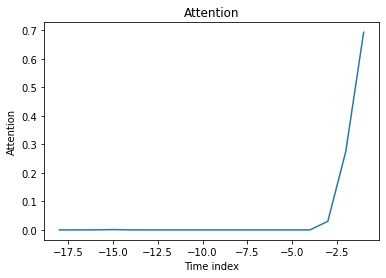

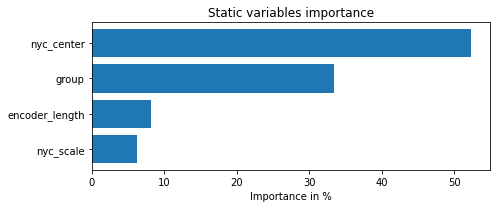

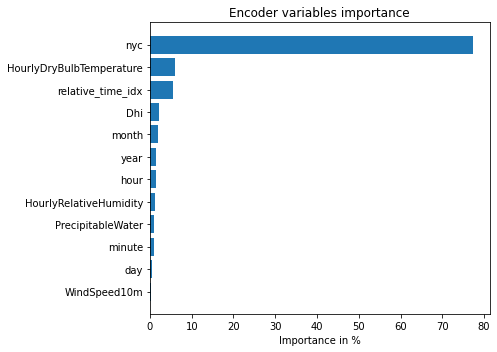

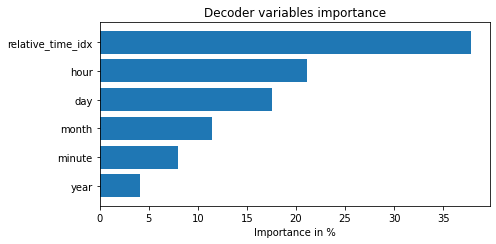

In [ ]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = tft.interpret_output(raw_predictions, reduction="sum")
tft.plot_interpretation(interpretation)

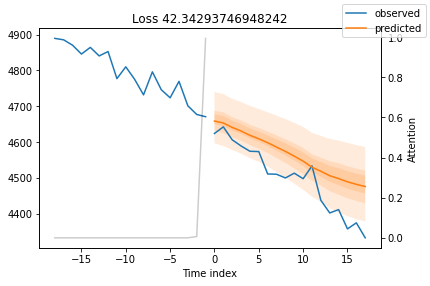

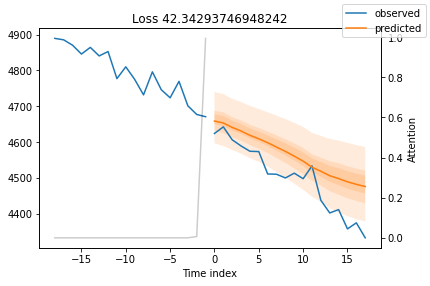

In [ ]:
tft.plot_prediction(x, raw_predictions, idx = 18, add_loss_to_title=True)


In [ ]:
# predictions, x = tft.predict(val_dataloader, return_x=True)
# predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(x, predictions)
# predictions_vs_actuals

In [ ]:
forecast =  tft.predict(val_dataloader, return_index = True)
df = pd.DataFrame(forecast[0].numpy(), index = forecast[1]['index'])
df = df.iloc[int(max_encoder_length/2) :-((max_prediction_length-1)*2)]

df.to_csv(f'{FORECAST_DIR}/TFT.csv')

In [ ]:
torch.save(tft.state_dict(), f'{FORECAST_DIR}/tft_weights.pth')

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
index,,,,,,,,,,,,,,,,,,
525880,4803.456543,4783.471680,4764.200684,4750.382324,4735.673340,4723.828125,4710.287109,4695.176758,4669.226562,4650.483887,4632.735840,4617.751953,4602.611816,4587.026855,4571.682129,4557.873047,4545.782227,4535.862305
525881,4779.761719,4761.203613,4742.059570,4728.044922,4714.764648,4702.417969,4689.346680,4666.668457,4649.702148,4632.694824,4616.125977,4600.114258,4584.954590,4569.314453,4553.863281,4539.747559,4528.049316,4518.058594
525882,4738.060547,4718.280762,4699.234863,4686.335938,4672.212891,4659.530762,4639.169922,4622.778320,4608.112793,4591.847656,4575.014160,4559.130859,4543.963867,4527.989258,4511.925781,4497.898438,4485.845215,4475.567383
525883,4753.437988,4733.791504,4717.281738,4705.010254,4691.413086,4671.050781,4657.508301,4641.794434,4627.310059,4611.024414,4594.261719,4578.444336,4562.827637,4546.178223,4530.350586,4516.098633,4503.860352,4489.659668
525884,4754.571289,4739.558105,4721.836914,4709.799805,4688.921387,4677.845703,4663.837891,4649.019531,4634.631836,4618.710938,4602.285645,4586.276367,4570.332031,4554.436523,4538.777832,4524.697266,4509.180664,4499.104492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630990,4926.513184,4900.952637,4884.401367,4872.890625,4860.816895,4849.689941,4827.713867,4809.199707,4791.966797,4772.706055,4755.434570,4738.273438,4722.030273,4704.419434,4686.205566,4669.530762,4654.290527,4639.958984
630990,4928.092285,4903.586914,4885.447266,4873.064453,4860.092285,4848.114746,4825.645996,4805.362305,4787.264160,4766.879883,4748.434570,4729.883301,4712.225098,4693.220215,4673.844238,4656.262695,4640.381348,4625.603516
630990,4915.938477,4892.363281,4871.298340,4856.667969,4841.484375,4827.632324,4805.216797,4782.238770,4763.193848,4740.862793,4720.798828,4700.294922,4680.706543,4659.953125,4639.238770,4620.634766,4604.005371,4588.679199
